# Détection et Reconnaissance de Chiffres

## Importer les bibliothèques nécessaires

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import cv2
import numpy as np
import joblib
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

## Charger les données MNIST

In [2]:
# Charger les données MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

# Convertir X en un tableau numpy
X_np = X.to_numpy()

(70000, 784) (70000,)


## Prétraitement des données

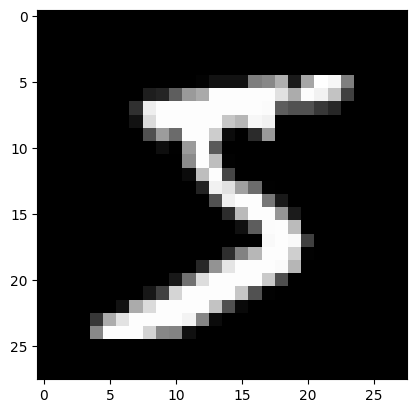

In [3]:
# Remodeler la première image à sa taille originale 28x28 et la convertir en entiers 8 bits
image = X_np[0].reshape(28, 28).astype('uint8')

# Utiliser matplotlib pour afficher l'image
plt.imshow(image, cmap='gray')
plt.show()

### Afficher les données

Afficher les 10 premières images de la base de données MNIST.

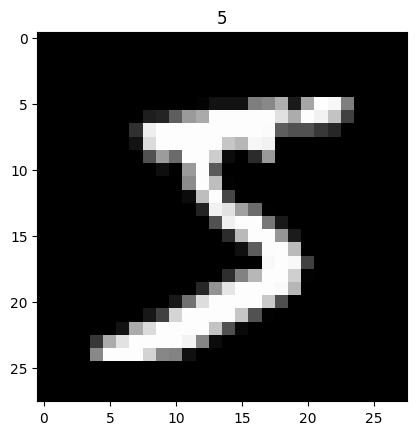

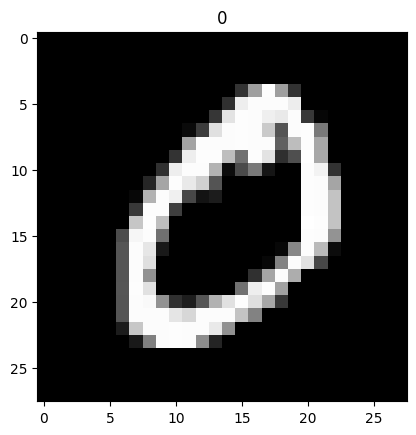

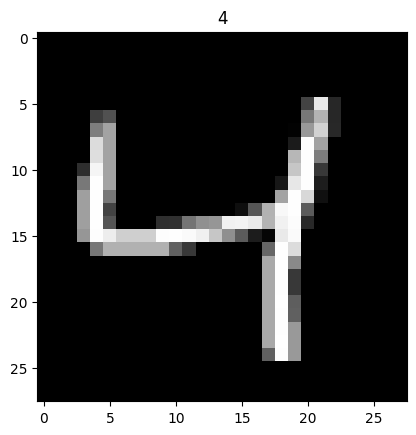

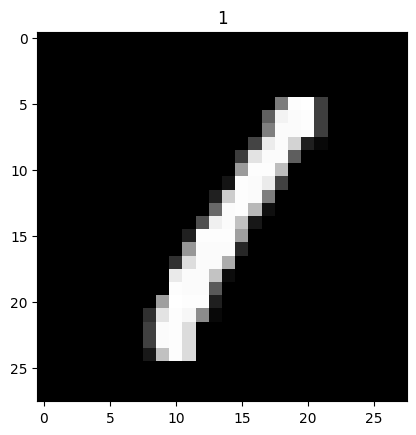

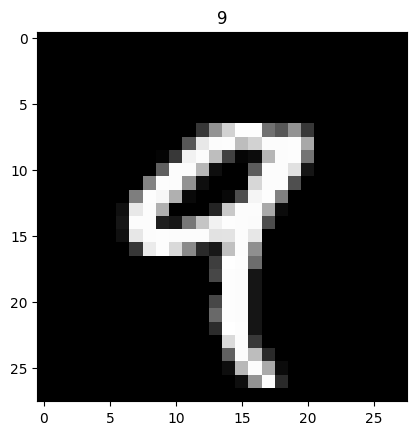

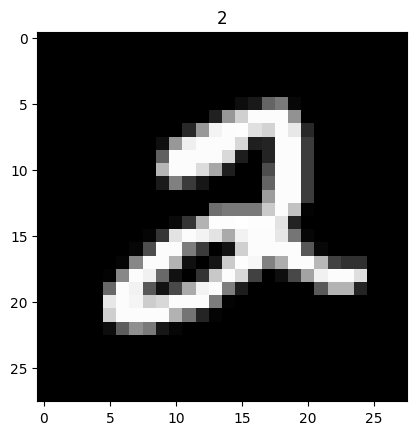

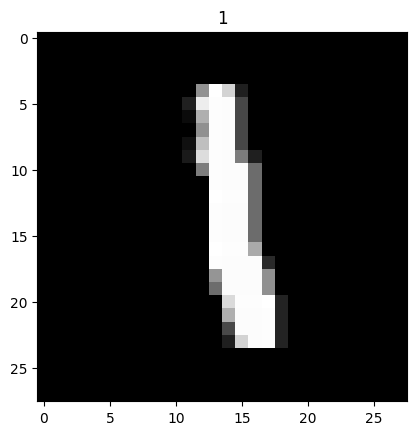

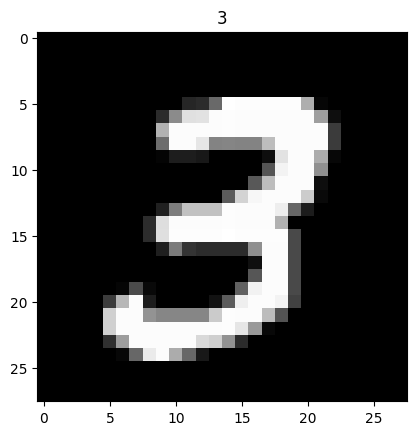

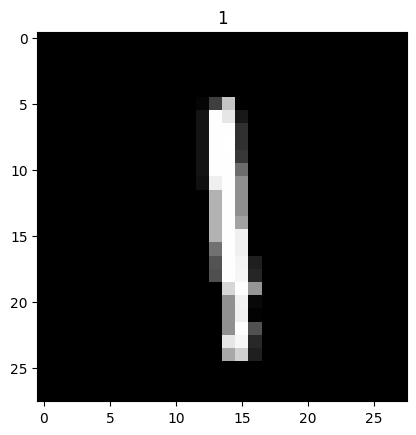

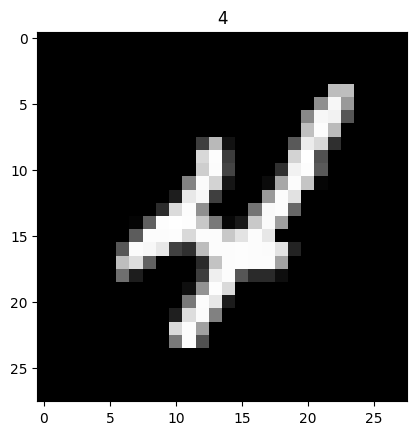

In [4]:
# Afficher les étiquettes des 10 premières images

for i in range(10):
    # Remodeler la première image à sa taille originale 28x28 et la convertir en entiers 8 bits
    image = X_np[i].reshape(28, 28).astype('uint8')

    # Utiliser matplotlib pour afficher l'image
    plt.imshow(image, cmap='gray')
    plt.title(y[i])
    plt.show()

### Afficher la distribution des classes

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

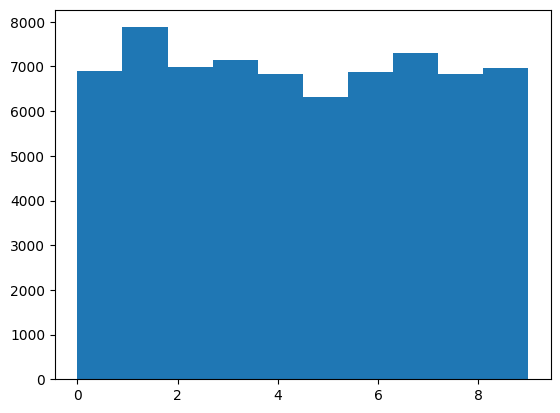

In [5]:
# Affichage de la distribution des étiquettes

plt.hist(y.astype('int'), bins=10)

## Division des données en ensembles d'entraînement et de test

In [6]:
# Prétraitement des données
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_np)

X_train, X_test, y_train, y_test = train_test_split(X_scaled[:6500], y[:6500], test_size=0.5, random_state=42)

# Creer le modèle avec MinMaxScaler et SVC

In [7]:
# Créer un pipeline qui inclut le MinMaxScaler et le modèle SVC avec les hyperparamètres optimisés
optimized_model = make_pipeline(MinMaxScaler(), SVC(C=10, gamma='scale', kernel='rbf', probability=True))

# Entraîner le modèle optimisé
optimized_model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=10, probability=True))])

## Evaluer le model

In [8]:
# Évaluer le modèle optimisé sur l'ensemble de test
y_pred_optimized = optimized_model.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       309
           1       0.96      0.98      0.97       372
           2       0.92      0.96      0.94       332
           3       0.95      0.93      0.94       349
           4       0.97      0.97      0.97       340
           5       0.96      0.93      0.95       275
           6       0.97      0.98      0.97       327
           7       0.95      0.96      0.96       356
           8       0.95      0.92      0.94       286
           9       0.97      0.92      0.94       304

    accuracy                           0.96      3250
   macro avg       0.96      0.95      0.96      3250
weighted avg       0.96      0.96      0.96      3250



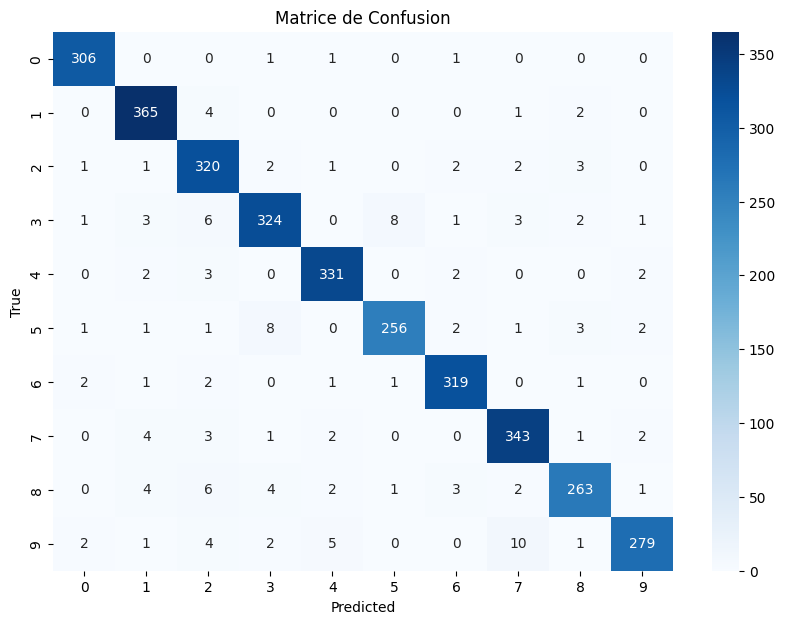

In [9]:
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de Confusion')
plt.show()

## Enregistrer le modèle

In [10]:
# Enregistrer le modèle optimisé
model_path = './models/DetectionReconize_optimized2.pkl'
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))
joblib.dump(optimized_model, model_path)

['./models/DetectionReconize_optimized2.pkl']

# Creer un model avec CNN

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner as kt

# Charger les données MNIST
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Convertir les étiquettes en entiers si elles sont de type 'category'
if isinstance(y_train, pd.Series):
    y_train = y_train.astype('int')
if isinstance(y_test, pd.Series):
    y_test = y_test.astype('int')

# Redimensionner les données pour qu'elles aient une dimension de canal
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Normaliser les données
X_train, X_test = X_train / 255.0, X_test / 255.0

# Définir le modèle pour Keras Tuner
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Définir le tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='./externe/my_dir',
    project_name='mnist_tuning'
)

# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Rechercher les meilleurs hyperparamètres
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Obtenir les meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

# Construire le meilleur modèle avec les meilleurs hyperparamètres
model = tuner.hypermodel.build(best_hps)

# Entraîner le modèle avec early stopping
history = model.fit(X_train, y_train, epochs=300, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Reloading Tuner from ./externe/my_dir\mnist_tuning\tuner0.json
Epoch 1/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.8141 - loss: 0.5738 - val_accuracy: 0.9880 - val_loss: 0.0440
Epoch 2/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9690 - loss: 0.1111 - val_accuracy: 0.9864 - val_loss: 0.0472
Epoch 3/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9793 - loss: 0.0701 - val_accuracy: 0.9875 - val_loss: 0.0487
Epoch 4/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9854 - loss: 0.0523 - val_accuracy: 0.9914 - val_loss: 0.0317
Epoch 5/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 37ms/step - accuracy: 0.9882 - loss: 0.0395 - val_accuracy: 0.9911 - val_loss: 0.0362
Epoch 6/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.9890 - loss: 0.0370 - val_accuracy: 0.9914 - val_loss: 0.0395
Epoch 7/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.9913 - loss: 0.0294 - val_accuracy: 0.9914 - val_loss: 0.0361
Epoch 

313/313 - 1s - 4ms/step - accuracy: 0.9914 - loss: 0.0317

Test accuracy: 0.9914000034332275


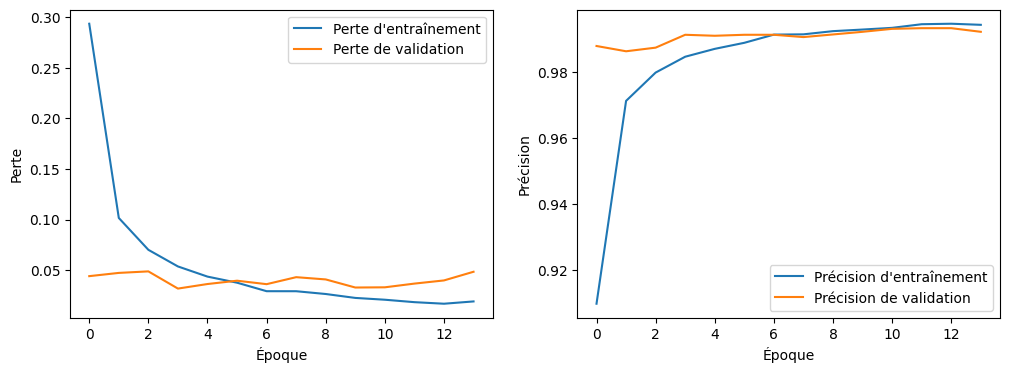

In [13]:
# Évaluer le modèle
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Afficher les courbes de perte et de précision
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend(loc='lower right')

plt.show()

In [14]:
import os
from tensorflow.keras.models import load_model

# Chemin du modèle
model_path = './models/DetectionReconize_CNN.h5'

# Créer le répertoire s'il n'existe pas
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Enregistrer le modèle optimisé
model.save(model_path)

# Charger le modèle enregistré
model = load_model(model_path)

# Évaluer le modèle chargé
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

313/313 - 2s - 5ms/step - accuracy: 0.9914 - loss: 0.0317

Test accuracy: 0.9914000034332275
